In [239]:
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
from sklearn.cluster import KMeans, AgglomerativeClustering
import imageio
import os
import copy

In [4]:
X = np.array([
    [1,1,1,1,1,1],
    [1,2,1,2,1,2],
    [2,1,2,2,1,1],
    [10,10,10,10,10,10],
    [10,11,10,10,10,10],
    [10,11,9,10,9,10],
    [20,20,20,20,20,20],
    [21,20,19,20,21,21],
    [19,21,19,20,21,20]
])

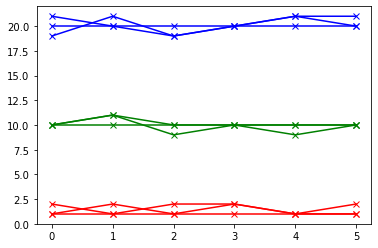

In [5]:
plt.plot(range(6), X[0], marker='x', c='r')
plt.plot(range(6), X[1], marker='x', c='r')
plt.plot(range(6), X[2], marker='x', c='r')
plt.plot(range(6), X[3], marker='x', c='g')
plt.plot(range(6), X[4], marker='x', c='g')
plt.plot(range(6), X[5], marker='x', c='g')
plt.plot(range(6), X[6], marker='x', c='b')
plt.plot(range(6), X[7], marker='x', c='b')
plt.plot(range(6), X[8], marker='x', c='b')
plt.show()

In [6]:
dataset = torch.tensor(X).unsqueeze(1).to(torch.float)
dataset.shape

torch.Size([9, 1, 6])

In [206]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn = nn.Conv1d(1,1,3,1)
        self.max_pool = nn.MaxPool1d(2,1)
        self.lstm_hidden_dim = 1
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=1,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, x):
        x = self.max_pool(F.relu(self.cnn(x)))
        x = x.permute(0, 2, 1)
        x, (_, _) = self.lstm(x)

        x = x[:, :, : self.lstm_hidden_dim] + x[:, :, self.lstm_hidden_dim :]
        x = x.permute(0,2,1)
        return x

class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Make each time series have 4 elements
        self.upsample = nn.Upsample(size=(4,))
        self.decoder = nn.ConvTranspose1d(1,1,3,1)
    
    def forward(self,x):
        x = self.upsample(x)
        return F.relu(self.decoder(x))


class TAE(nn.Module):
    def __init__(self, encoder, decoder) -> None:
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder 

    def forward(self, x):
        l = self.encoder(x)
        x_prime = self.decoder(l)
        return l, x_prime


class ClusterLayer(nn.Module):
    def __init__(self, encoder, centroids) -> None:
        super().__init__()
        self.encoder = encoder 
        self.centroids = nn.Parameter(centroids)
    
    def euclidean_distance(self, x, y):
        dists = torch.zeros(9,3)

        for i in range(9):
            d = []
            for j in range(3):
                a = x[i].flatten()
                b = y[j].flatten()
                euc = ((a-b)**2).sum()
                dists[i][j] = euc
        return dists

    def students_t_distribution_kernel(self, x, alpha=1):
        num = torch.pow((1 + x / alpha), -(alpha + 1) / 2)
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, 3)
        return num / denom

    def target_distribution(self, Q):
        F = Q.sum(dim=0)
        num = (Q ** 2) / F
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, Q.shape[-1])
        return num / denom

    def forward(self, x):
        l = self.encoder(x)
        D = self.euclidean_distance(l, self.centroids)
        Q = self.students_t_distribution_kernel(D)
        P = self.target_distribution(Q)
        return l, torch.log(Q), torch.log(P), Q, P

In [246]:
def euclidean_distance(x, y):
    """
    Return (x.shape[0], y.shape[0]) matrix where each element is d(x_i, y_i) 
    where x_i is the i-th time series in x => x_i = x[i].
    """
    a = x.repeat(1, 1, y.shape[0]).permute(0, 2, 1)
    b = y.repeat(x.shape[0], 1, 1).reshape(a.shape)
    return torch.sqrt(torch.sum((a - b) ** 2, dim=2))


def train_TAE(ae, n_epochs):
    optimizer = optim.Adam(ae.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    sheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        factor=0.5,
        patience=50,
        threshold=0.001
    )

    latents = []
    losses = [] 

    pbar = tqdm(range(n_epochs))

    for i in pbar:
        l, x_prime = ae(dataset)
        loss = criterion(x_prime, dataset)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sheduler.step(loss.item())

        latents.append(l.detach().numpy())
        losses.append(loss.item())
        
        if i % 100 == 0:
            pbar.set_description(f'{round(loss.item(), 6)}')
    return latents, losses

In [218]:
decoder = Decoder()
encoder = Encoder()
ae = TAE(encoder, decoder)

latents, losses = train_TAE(ae, n_epochs=20000)

1.941332: 100%|██████████| 20000/20000 [00:38<00:00, 516.74it/s]


In [219]:
l = encoder(dataset).detach().squeeze(1).numpy()

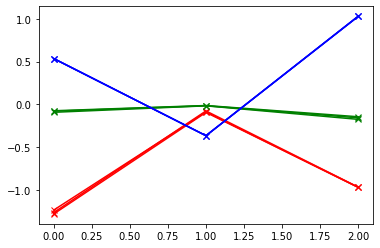

In [220]:
plt.plot(range(3), l[0], marker='x', c='r')
plt.plot(range(3), l[1], marker='x', c='r')
plt.plot(range(3), l[2], marker='x', c='r')
plt.plot(range(3), l[3], marker='x', c='g')
plt.plot(range(3), l[4], marker='x', c='g')
plt.plot(range(3), l[5], marker='x', c='g')
plt.plot(range(3), l[6], marker='x', c='b')
plt.plot(range(3), l[7], marker='x', c='b')
plt.plot(range(3), l[8], marker='x', c='b')
plt.show()

In [256]:
def euclidean_distance(x, y):
    dists = torch.zeros(9,9)

    for i in range(9):
        d = []
        for j in range(9):
            a = x[i].flatten()
            b = y[j].flatten()
            euc = ((a-b)**2).sum()
            dists[i][j] = euc
    return dists

In [274]:
latent, x_prime = ae(dataset)

In [275]:
latent = latent.squeeze(1)

In [276]:
similarity_matrix = euclidean_distance(latent, latent)

In [277]:
similarity_matrix

tensor([[0.0000e+00, 5.7681e-04, 2.0865e-03, 2.1109e+00, 2.1442e+00, 2.0508e+00,
         7.3704e+00, 7.3755e+00, 7.3769e+00],
        [5.7681e-04, 0.0000e+00, 9.7639e-04, 2.0634e+00, 2.0963e+00, 2.0039e+00,
         7.3062e+00, 7.3114e+00, 7.3128e+00],
        [2.0865e-03, 9.7639e-04, 0.0000e+00, 2.0017e+00, 2.0344e+00, 1.9428e+00,
         7.2068e+00, 7.2121e+00, 7.2135e+00],
        [2.1109e+00, 2.0634e+00, 2.0017e+00, 0.0000e+00, 1.9474e-04, 4.8810e-04,
         1.9066e+00, 1.9111e+00, 1.9118e+00],
        [2.1442e+00, 2.0963e+00, 2.0344e+00, 1.9474e-04, 0.0000e+00, 1.2722e-03,
         1.8723e+00, 1.8768e+00, 1.8775e+00],
        [2.0508e+00, 2.0039e+00, 1.9428e+00, 4.8810e-04, 1.2722e-03, 0.0000e+00,
         1.9644e+00, 1.9690e+00, 1.9697e+00],
        [7.3704e+00, 7.3062e+00, 7.2068e+00, 1.9066e+00, 1.8723e+00, 1.9644e+00,
         0.0000e+00, 9.4099e-06, 1.0849e-05],
        [7.3755e+00, 7.3114e+00, 7.2121e+00, 1.9111e+00, 1.8768e+00, 1.9690e+00,
         9.4099e-06, 0.0000e+0

In [278]:
similarity_matrix = similarity_matrix.detach().numpy()

clustering_assignments = AgglomerativeClustering(
    n_clusters=3, affinity="precomputed", linkage="complete",
).fit_predict(similarity_matrix)

centroids = []
for i in np.unique(clustering_assignments):
    centroid = latent[clustering_assignments == i].mean(dim=0).unsqueeze(0)
    centroids.append(centroid)
centroids = torch.cat(centroids)

In [279]:
centroids

tensor([[-1.2612, -0.0872, -0.9701],
        [-0.0831, -0.0163, -0.1600],
        [ 0.5344, -0.3670,  1.0288]], grad_fn=<CatBackward0>)

In [280]:
cl_main = ClusterLayer(encoder=encoder, centroids=centroids)

In [281]:
centroids = centroids.detach()

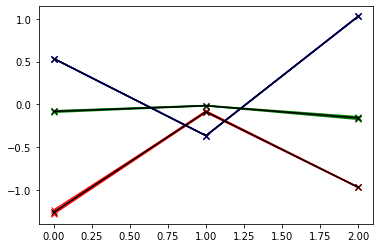

In [282]:
plt.plot(range(3), l[0], marker='x', c='r')
plt.plot(range(3), l[1], marker='x', c='r')
plt.plot(range(3), l[2], marker='x', c='r')
plt.plot(range(3), l[3], marker='x', c='g')
plt.plot(range(3), l[4], marker='x', c='g')
plt.plot(range(3), l[5], marker='x', c='g')
plt.plot(range(3), l[6], marker='x', c='b')
plt.plot(range(3), l[7], marker='x', c='b')
plt.plot(range(3), l[8], marker='x', c='b')
plt.plot(range(3), centroids[0], marker='x', c='black')
plt.plot(range(3), centroids[1], marker='x', c='black')
plt.plot(range(3), centroids[2], marker='x', c='black')
plt.show()

In [283]:
optimizer = optim.SGD(cl.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=50, verbose=1)
mse = nn.MSELoss()
kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

In [284]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def fit_DTC(cl, weight, coef, output_name):
    optimizer = optim.SGD(cl.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=50, verbose=1)
    mse = nn.MSELoss()
    kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

    filenames = []

    last_loss = float('inf')
    tol = 0.001
    patience_counter = 0
    patience_tol = 1000

    all_losses = []
    all_mse = []
    all_kl = []

    pbar = tqdm(range(3000))

    for i in pbar:
        l, log_P, log_Q, P, Q = cl(dataset)
        x_prime = decoder(l)

        mse_loss = mse(dataset, x_prime)
        kl_loss = kl(Q, P)


        # inter_centroid_loss = 0

        # inter_centroid_loss += mse(cl.centroids[0], cl.centroids[1])
        # inter_centroid_loss += mse(cl.centroids[0], cl.centroids[2])
        # inter_centroid_loss += mse(cl.centroids[1], cl.centroids[2])

        diff_loss = 1 - P.max(dim=1)[0].sum()

    
        dtc_loss = mse_loss + weight * kl_loss + coef * diff_loss

        all_losses.append(dtc_loss.item())
        all_mse.append(mse_loss.item())
        all_kl.append(kl_loss.item())

        optimizer.zero_grad()
        dtc_loss.backward()
        optimizer.step()

        
        if i % 100 == 0 and i != 0:
            fig, ax = plt.subplots(2,2)

            ls = [x.flatten().detach() for x in l]
            cents = [x.flatten().detach() for x in cl.centroids]

            ax[0][0].plot(range(len(all_mse)), all_mse)
            ax[0][0].set_xlabel('$Epoch$')
            ax[0][0].set_ylabel('$Loss$')
            ax[0][0].set_title(f'MSE')

            ax[0][1].plot(range(len(all_kl)), all_kl)
            ax[0][1].set_xlabel('$Epoch$')
            ax[0][1].set_ylabel('$Loss$')
            ax[0][1].set_title(f'KL Divergence Loss')

            ax[1][0].plot(range(3), ls[0], c='r')
            ax[1][0].plot(range(3), ls[1], c='r')
            ax[1][0].plot(range(3), ls[2], c='r')
            ax[1][0].plot(range(3), ls[3], c='g')
            ax[1][0].plot(range(3), ls[4], c='g')
            ax[1][0].plot(range(3), ls[5], c='g')
            ax[1][0].plot(range(3), ls[6], c='b')
            ax[1][0].plot(range(3), ls[7], c='b')
            ax[1][0].plot(range(3), ls[8], c='b')
            ax[1][0].plot(range(3), cents[0], c='black', label='Centroids')
            ax[1][0].plot(range(3), cents[1], c='black')
            ax[1][0].plot(range(3), cents[2], c='black')
            ax[1][0].set_xlabel('$X$')
            ax[1][0].set_ylabel('$Y$')
            ax[1][0].set_title('Latent space')
            ax[1][0].legend()

            ax[1][1].plot(range(len(all_losses)), all_losses)
            ax[1][1].set_xlabel('$Epoch$')
            ax[1][1].set_ylabel('$Loss$')
            ax[1][1].set_title(f'DTC')

            fig.set_size_inches(25, 15)

            filename = f'temp/img_{i}.png'
            filenames.append(filename)

            # plt.show()
            # 0/0

            plt.savefig(filename)
            plt.close()

            pbar.set_description(f'{round(dtc_loss.item(), 8)}')

        # if abs(last_loss - dtc_loss.item()) < tol:
        #     if patience_counter >= patience_tol:
        #         break
        #     patience_counter += 1
        # else:
        #     last_loss = dtc_loss.item()
        #     patience_counter = 0

        # scheduler.step(dtc_loss.item())
        # all_losses.append(dtc_loss.item())

    # build gif
    with imageio.get_writer(f'{output_name}.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)
            
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [285]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 0, 'weight_1_0.0')

73.59699249: 100%|██████████| 3000/3000 [00:14<00:00, 204.30it/s]


In [286]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 1, 'weight_1_1')

51.81155777: 100%|██████████| 3000/3000 [00:13<00:00, 218.35it/s]


In [287]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 2, 'weight_1_2')

52.71987915: 100%|██████████| 3000/3000 [00:13<00:00, 215.68it/s]


In [234]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 5, 'weight_1_5')

-13.69162941: 100%|██████████| 3000/3000 [00:13<00:00, 216.44it/s]


In [235]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 10, 'weight_1_10')

-60.73234177: 100%|██████████| 3000/3000 [00:13<00:00, 216.59it/s]


In [188]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def fit_DTC(cl, weight, coef, output_name):
    optimizer = optim.SGD(cl.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=50, verbose=1)
    mse = nn.MSELoss()
    kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

    filenames = []

    last_loss = float('inf')
    tol = 0.001
    patience_counter = 0
    patience_tol = 1000

    all_losses = []
    all_mse = []
    all_kl = []

    pbar = tqdm(range(3000))

    for i in pbar:
        l, P, Q = cl(dataset)
        x_prime = decoder(l)

        mse_loss = mse(dataset, x_prime)
        kl_loss = kl(Q, P)


        inter_centroid_loss = 0

        inter_centroid_loss += mse(cl.centroids[0], cl.centroids[1])
        inter_centroid_loss += mse(cl.centroids[0], cl.centroids[2])
        inter_centroid_loss += mse(cl.centroids[1], cl.centroids[2])

    
        dtc_loss = mse_loss + weight * kl_loss - coef * inter_centroid_loss
        # dtc_loss = mse_loss + weight * kl_loss - coef * P.sum()

        all_losses.append(dtc_loss.item())
        all_mse.append(mse_loss.item())
        all_kl.append(kl_loss.item())

        optimizer.zero_grad()
        dtc_loss.backward()
        optimizer.step()

        
        if i % 100 == 0 and i != 0:
            fig, ax = plt.subplots(2,2)

            ls = [x.flatten().detach() for x in l]
            cents = [x.flatten().detach() for x in cl.centroids]

            ax[0][0].plot(range(len(all_mse)), all_mse)
            ax[0][0].set_xlabel('$Epoch$')
            ax[0][0].set_ylabel('$Loss$')
            ax[0][0].set_title(f'MSE')

            # ax[0][1].plot(range(len(all_kl)), all_kl)
            ax[0][1].plot(range(3), ls[0], c='r')
            ax[0][1].plot(range(3), ls[1], c='r')
            ax[0][1].plot(range(3), ls[2], c='r')
            ax[0][1].plot(range(3), ls[3], c='g')
            ax[0][1].plot(range(3), ls[4], c='g')
            ax[0][1].plot(range(3), ls[5], c='g')
            ax[0][1].plot(range(3), ls[6], c='b')
            ax[0][1].plot(range(3), ls[7], c='b')
            ax[0][1].plot(range(3), ls[8], c='b')
            ax[0][1].set_xlabel('$Epoch$')
            ax[0][1].set_ylabel('$Loss$')
            ax[0][1].set_title(f'KL Divergence Loss')

            ax[1][0].plot(range(3), ls[0], c='r')
            ax[1][0].plot(range(3), ls[1], c='r')
            ax[1][0].plot(range(3), ls[2], c='r')
            ax[1][0].plot(range(3), ls[3], c='g')
            ax[1][0].plot(range(3), ls[4], c='g')
            ax[1][0].plot(range(3), ls[5], c='g')
            ax[1][0].plot(range(3), ls[6], c='b')
            ax[1][0].plot(range(3), ls[7], c='b')
            ax[1][0].plot(range(3), ls[8], c='b')
            ax[1][0].plot(range(3), cents[0], c='black', label='Centroids')
            ax[1][0].plot(range(3), cents[1], c='black')
            ax[1][0].plot(range(3), cents[2], c='black')
            ax[1][0].set_xlabel('$X$')
            ax[1][0].set_ylabel('$Y$')
            ax[1][0].set_title('Latent space')
            ax[1][0].legend()

            ax[1][1].plot(range(len(all_losses)), all_losses)
            ax[1][1].set_xlabel('$Epoch$')
            ax[1][1].set_ylabel('$Loss$')
            ax[1][1].set_title(f'DTC')

            fig.set_size_inches(25, 15)

            filename = f'temp/img_{i}.png'
            filenames.append(filename)

            # plt.show()
            # 0/0

            plt.savefig(filename)
            plt.close()

            pbar.set_description(f'{round(dtc_loss.item(), 8)}')

        # if abs(last_loss - dtc_loss.item()) < tol:
        #     if patience_counter >= patience_tol:
        #         break
        #     patience_counter += 1
        # else:
        #     last_loss = dtc_loss.item()
        #     patience_counter = 0

        # scheduler.step(dtc_loss.item())
        # all_losses.append(dtc_loss.item())

    # build gif
    with imageio.get_writer(f'{output_name}.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)
            
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [288]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 0.01, 'weight_1_1.1')

73.50751495: 100%|██████████| 3000/3000 [00:13<00:00, 220.41it/s]


In [163]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 0.0001, 'weight_1_0.0001')

61.19128799: 100%|██████████| 3000/3000 [00:14<00:00, 209.04it/s]


In [155]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 0.01, 'weight_1_0.01')

60.99385452: 100%|██████████| 3000/3000 [00:13<00:00, 219.73it/s]


In [156]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 0.001, 'weight_1_0.001')

61.18084717: 100%|██████████| 3000/3000 [00:13<00:00, 219.34it/s]


In [157]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 0.05, 'weight_1_0.05')

-38.8767128: 100%|██████████| 3000/3000 [00:13<00:00, 220.28it/s] 


* Algo
    * Binary search penalty value until doesnt diverge
    * And that clusters are just being moved away from each other
    * Probably should penalise the sum of the distance to the closest cluster
    * Also all latent representations shouldnt merge into one|